Image segmentation entails partitioning image pixels into different classes. Some applications include identifying tumour regions in medical images, separating land and water areas in drone images, etc. Unlike classification, where CNNs output a class probability score vector, segmentation requires CNNs to output an image.Accordingly, traditional CNN architectures are tweaked to yield the desired result. An array of architectures, including transformers, are available to segment images. But besides improving network design, researchers are constantly experimenting with other hacks to improve segmentation performance. Recently, I came across a work that briefly described the idea of calculating loss at multiple output levels (deep-supervision loss). In this post, I want to share the same. 
We'll implement a model similar to UNet, a commonly employed segmentation architecture, and train it with supervision loss using the Keras model subclass. We'll segment the space occupied by lungs in chest xrays. It's a fairly simple and crude problem, so let's not focus on model performance. The aim is to learn how to use supervision loss.

# IMPORTS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Lambda, Conv2D, Conv2DTranspose,MaxPooling2D, concatenate,UpSampling2D,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold
from tensorflow.keras.losses import BinaryCrossentropy
import random

# CONFIGURATION

In [2]:
class config:
    seed = 42
    img_size = [256,256]
    msk_mode = 'grayscale'
    img_mode = 'grayscale'
    msk_channels = 1
    img_channels = 1
    img_type_num = 0 # Read images as grayscale
    msk_type_num = 0 # Read masks as grayscale
    backbone = None
    activation = None
    batch_size = 16
    train_epochs = 10
    lr = 1e-4

# READING PATHS

In [3]:
df = pd.DataFrame(columns=['img_path','msk_path','img_shape','msk_shape','class'])
for cat in ['COVID']:
    dir_ = f"../input/covid19-radiography-database/COVID-19_Radiography_Dataset/{cat}"
    for f in os.listdir(f"{dir_}/images"):
        s1 = cv2.imread(f"{dir_}/images/{f}",config.img_type_num).shape
        s2 = cv2.imread(f"{dir_}/masks/{f}",config.msk_type_num).shape
        dic={'img_path':f"{dir_}/images/{f}",'msk_path':f"{dir_}/masks/{f}",'img_shape':s1,
            'msk_shape':s2}
        df = df.append(dic,ignore_index=True)

In [4]:
df['img_shape'].value_counts()

(299, 299)    3616
Name: img_shape, dtype: int64

In [5]:
df['msk_shape'].value_counts()

(256, 256)    3616
Name: msk_shape, dtype: int64

In [6]:
def read_imgs_msk(id_):
    img = cv2.imread(df.loc[id_,'img_path'],config.img_type_num)
    msk = cv2.imread(df.loc[id_,'msk_path'],config.msk_type_num)
    img = cv2.resize(img,config.img_size)
    msk = cv2.resize(msk,config.img_size)
    return img,msk

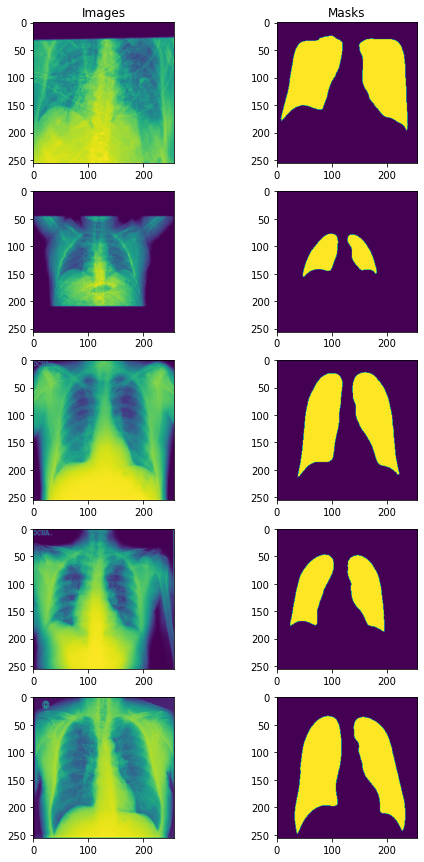

In [7]:
f,ax = plt.subplots(5,2,figsize=(8,15))
for i,id_ in enumerate([69,178,963,2417,3000]):
    img,msk = read_imgs_msk(id_)
    ax[i][0].imshow(img)
    ax[i][1].imshow(msk)
ax[0][0].set_title('Images')
ax[0][1].set_title('Masks')
plt.show()

In [8]:
def img_dataset(df_inp,path_img,path_mask,batch):
    img_gen=ImageDataGenerator(rescale=1./255.)
    df_img = img_gen.flow_from_dataframe(dataframe=df_inp,
                                     x_col=path_img,
                                     class_mode=None,
                                     batch_size=batch,
                                    color_mode=config.img_mode,
                                         seed=config.seed,
                                     target_size=config.img_size)
    df_mask=img_gen.flow_from_dataframe(dataframe=df_inp,
                                     x_col=path_mask,
                                     class_mode=None,
                                     batch_size=batch,
                                    color_mode=config.msk_mode,
                                        seed=config.seed,
                                     target_size=config.img_size)
    data_gen = zip(df_img,df_mask)
    return data_gen

# Loss functions

We'll use binarycrossentropy as loss function and track the dice coefficient as a metric.

In [9]:
def dice_coef(y_true, y_pred):
    eps=K.epsilon()
    y_pred = tf.cast(tf.math.greater(y_pred,0.5),'float32')
    intersec=K.sum(y_true* y_pred,axis=[1,2])
    dice= (((2* intersec + eps) / (K.sum(y_true,axis=[1,2]) + K.sum(y_pred,axis=[1,2]) + eps)))
    dice=K.mean(dice)
    return dice

def dice_loss(y_true,y_pred):
    return 1-dice_coef(y_true,y_pred)

Conventionally, CNNs are deft at identifying what's present in an image. For segmentation, CNNs also need to learn to position image constituents precisely. UNet is equipped to do just that. The original UNet paper describes it as a network divided into two parts - contracting (encoder) and expansive (decoder). Let's start with the encoder part (Note, I have made some minor modifications to the architecture presented in the [Unet paper](https://arxiv.org/abs/1505.04597))
The encoder functions like a general CNN. It continually breaks down the input to discern features associated with the objects in an image. This process repeats in multiple blocks (encoder blocks). Each block consists of the following:

1. Two convolutional layers with padding and (3,3) kernels in succession (we'll call this a convolution block). One may also include batch normalisation/dropout layers wherever necessary [The original paper used unpadded convolutions]. We'll use relu as activation function.
2. A max-pooling layer with stride of 2 to squeeze the image down

This first block is followed by three more similar blocks having filters = 128,256,512. Together, the four blocks form the contraction path/encoder.

Next, we have the mid block.It takes the max-pooled output from the previous encoder block and runs it through two successive (3,3) convolutions of 1024 filters. Just like the convolution block, you ask? Yes, only this time, the output does not pass for max pooling. Ergo, we'll use conv_block, instead of encoder_block, to create the middle section.

Finally, we have decoder blocks which upsample the the features and create a final segmentation map. They use skip connections to do so.

In [10]:
def conv_block(inp,filters,padding='same',activation='relu'):
    """
    Convolution block of a UNet encoder
    """
    x=Conv2D(filters,(3,3),padding=padding,activation=activation)(inp)
    x=Conv2D(filters,(3,3),padding=padding)(x)
    x=BatchNormalization(axis=3)(x)
    x=Activation(activation)(x)
    return x
def encoder_block(inp,filters,padding='same',pool_stride=2,activation='relu'):
    """
    Encoder block of a UNet passes the result from the convolution block
    above to a max pooling layer
    """
    x=conv_block(inp,filters,padding,activation)
    p=MaxPooling2D(pool_size=(2,2),strides=pool_stride)(x)
    return x,p
def decoder_block(inp,filters,concat_layer,padding='same'):
    #Upsample the feature maps
    x=Conv2DTranspose(filters,(2,2),strides=(2,2),padding=padding)(inp)
    x=concatenate([x,concat_layer])#Concatenation/Skip conncetion with conjuagte encoder
    x=conv_block(x,filters)#Passed into the convolution block above
    return x

# Final Model
The final model includes outputs from the last and the second last decoders. We use outputs from multiple decoders to leverage [supervision loss](http://https://arxiv.org/pdf/2110.03352v2.pdf)

In [11]:
inputs=Input((256,256,1))
d1,p1=encoder_block(inputs,64)
d2,p2=encoder_block(p1,128)
d3,p3=encoder_block(p2,256)
d4,p4=encoder_block(p3,512)
mid=conv_block(p4,1024) #Midsection
e2=decoder_block(mid,512,d4) #Conjugate of encoder 4
e3=decoder_block(e2,256,d3) #Conjugate of encoder 3
e4=decoder_block(e3,128,d2) #Conjugate of encoder 2 
o1 = Conv2D(1,(1,1),activation=None)(e4) # Output from 2nd last decoder
e5=decoder_block(e4,64,d1) #Conjugate of encoder 1
outputs = Conv2D(1, (1,1),activation=None)(e5) #Final Output
ml=Model(inputs=[inputs],outputs=[outputs,o1],name='Unet')

2022-09-23 20:28:47.143590: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-23 20:28:47.240438: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-23 20:28:47.241293: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-23 20:28:47.242460: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [12]:
ml.summary()

Model: "Unet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d_1[0][0]                   
_______________________________________________________________________________________________

In [13]:
skf = KFold(n_splits=5)
for fold, (train_idx, val_idx) in enumerate(skf.split(df)):
    df.loc[val_idx, 'fold'] = fold

# Keras Subclass Model
Keras subclass model for training the model over supervision loss. We'll declare functions train step and test step to override model.fit execution

In [14]:
class network(tf.keras.Model):
    
    def __init__(self,model,loss,metric,loss_weights):
        super().__init__()
        self.loss = loss
        self.metric = metric
        self.model = model
        self.loss_weights = loss_weights
    
    def call(self,inputs,training):
        out = self.model(inputs)
        if training==True:
            return out
        else:
            if type(out) == list:
                return out[0]
            else:
                return out
    
    def calc_supervision_loss(self,y_true,y_preds):
        loss = 0
        for i,pred in enumerate(y_preds):
            y_resized = tf.image.resize(y_true,[*pred.shape[1:3]])
            loss+= self.loss_weights[i+1] * self.loss(y_resized,pred)
            return loss
    
    def train_step(self,data):
        x,y = data
        with tf.GradientTape() as tape:
            y_preds = self(x,training=True)
            if type(y_preds) == list:
                loss = self.loss_weights[0] * self.loss(y,y_preds[0])
                acc = self.metric(y,y_preds[0])
                loss += self.calc_supervision_loss(y,y_preds[1:])
            else:
                loss = self.loss(y,y_preds)
                acc = self.metric(y,y_preds)
        trainable_vars = self.trainable_variables #Network trainable parameters
        gradients = tape.gradient(loss, trainable_vars) #Calculating gradients 
        #Applying gradients to optimizer
        self.optimizer.apply_gradients(zip(gradients, trainable_vars)) 
        return loss,acc
    
    def test_step(self,data):
        x,y=data
        y_pred = self(x,training=False)
        loss = self.loss(y,y_pred)
        acc = self.metric(y,y_pred)
        return loss,acc

In [15]:
for fold in range(5):
    if fold == 0:
        train_ds = df[df['fold']!=fold]
        train_ds.reset_index(inplace=True,drop=True)
        val_ds = df[df['fold']==fold]
        val_ds.reset_index(inplace=True,drop=True)
        train=img_dataset(train_ds,'img_path','msk_path',config.batch_size)
        val=img_dataset(val_ds,'img_path','msk_path',config.batch_size)
        opt = Adam(learning_rate=config.lr, epsilon=None, amsgrad=False,beta_1=0.9,beta_2=0.99)
        
        model = network(ml,BinaryCrossentropy(),dice_coef,[1,0.5])
        model.compile(optimizer=opt,loss=BinaryCrossentropy(),metrics=[dice_coef])
        best_val = np.inf
        for epoch in range(config.train_epochs):
            epoch_train_loss = 0.0
            epoch_train_acc=0.0
            epoch_val_acc=0.0
            epoch_val_loss=0.0
            num_batches = 0
            for x in train:
                if num_batches > (len(train_ds)//config.batch_size):
                    break
                a,b = model.train_step(x)
                epoch_train_loss+=a
                epoch_train_acc+=b
                num_batches+=1
            epoch_train_loss = epoch_train_loss/num_batches
            epoch_train_acc = epoch_train_acc/num_batches
            num_batches_v=0
            for x in val:
                if num_batches_v > (len(val_ds)//config.batch_size):
                    break
                a,b = model.test_step(x)
                epoch_val_loss+=a
                epoch_val_acc+=b
                num_batches_v+=1
            epoch_val_loss=epoch_val_loss/num_batches_v
            if epoch_val_loss < best_val:
                best_val = epoch_val_loss
                print('---Validation Loss improved,saving model---')
                model.model.save('./weights',save_format='tf')
            epoch_val_acc=epoch_val_acc/num_batches_v
            template = ("Epoch: {}, TrainLoss: {}, TainAcc: {}, ValLoss: {}, ValAcc {}")
            print(template.format(epoch,epoch_train_loss,epoch_train_acc,
                                  epoch_val_loss,epoch_val_acc))

Found 2892 validated image filenames.
Found 2892 validated image filenames.
Found 724 validated image filenames.
Found 724 validated image filenames.


2022-09-23 20:28:53.666068: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


---Validation Loss improved,saving model---


2022-09-23 20:30:45.947376: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Epoch: 0, TrainLoss: 0.900826632976532, TainAcc: 0.6187810301780701, ValLoss: 0.5239875912666321, ValAcc 6.800767848175182e-12
---Validation Loss improved,saving model---
Epoch: 1, TrainLoss: 0.485687255859375, TainAcc: 0.7778673768043518, ValLoss: 0.3437858521938324, ValAcc 0.7603207230567932
Epoch: 2, TrainLoss: 0.2958390414714813, TainAcc: 0.8627215623855591, ValLoss: 0.36139360070228577, ValAcc 0.76483553647995
---Validation Loss improved,saving model---
Epoch: 3, TrainLoss: 0.24885748326778412, TainAcc: 0.886476457118988, ValLoss: 0.2510852515697479, ValAcc 0.848009467124939
---Validation Loss improved,saving model---
Epoch: 4, TrainLoss: 0.22107118368148804, TainAcc: 0.8914097547531128, ValLoss: 0.13533513247966766, ValAcc 0.9132657051086426
Epoch: 5, TrainLoss: 0.19059793651103973, TainAcc: 0.9082144498825073, ValLoss: 0.23706448078155518, ValAcc 0.7925510406494141
Epoch: 6, TrainLoss: 0.14917246997356415, TainAcc: 0.9308711886405945, ValLoss: 0.13559451699256897, ValAcc 0.91026

The predicted masks are quite accurate. The model has a validation dice score of 0.96 and validation loss of 0.55. However, as discussed we should not read much into these values as the problem at hand was crude. The aim was to show how supervision loss can be used. In the [paper](http://https://arxiv.org/abs/2110.03352v2) referenced, the authors used outputs from three decoders for calculating the final loss.

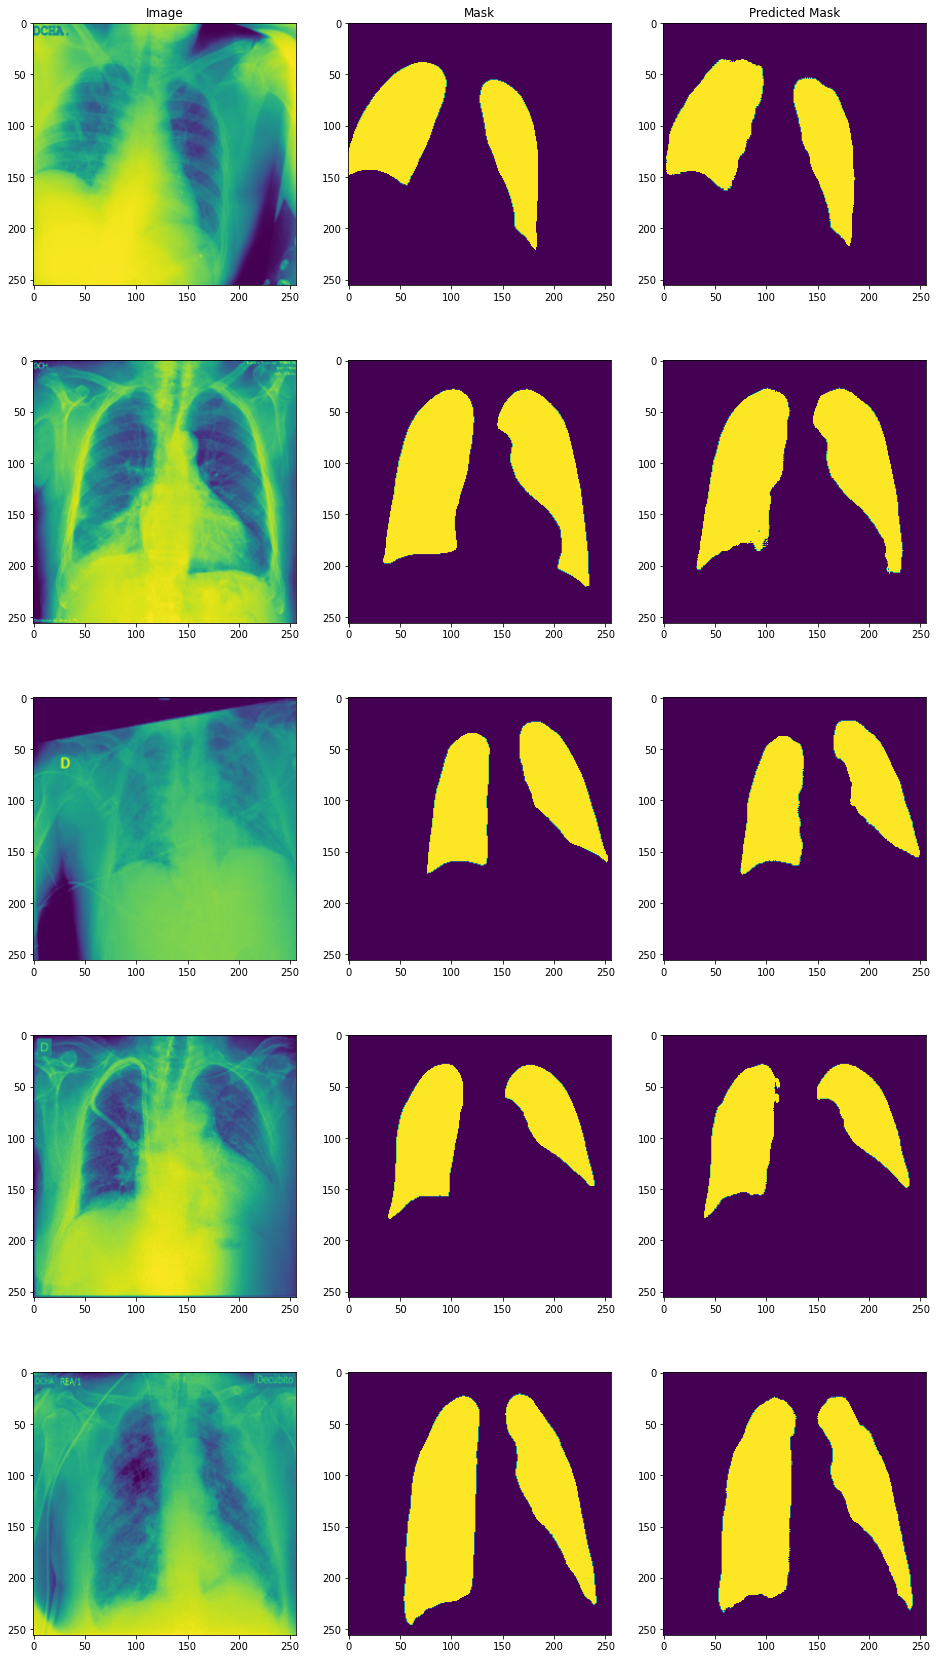

In [16]:
f,ax = plt.subplots(5,3,figsize=(16,30))
l = df[df['fold']==0].index.tolist()
l = random.sample(l,5)
for i,id_ in enumerate(l):
    img,msk = read_imgs_msk(id_)
    ax[i][0].imshow(img)
    ax[i][1].imshow(msk)
    img = np.reshape(img,(1,*config.img_size,config.img_channels))
    pred = ml(img/np.max(img))
    pred = tf.cast(tf.math.greater(pred[0],0.5),'float32')
    ax[i][2].imshow(pred[0])
ax[0][0].set_title('Image')
ax[0][1].set_title('Mask')
ax[0][2].set_title('Predicted Mask')
plt.show()